### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Lets test different spectral cleaning parameters

Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

Read the spectral data

In [3]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Filter the effective range from 380/400 to 1800 cm-1

In [4]:
#df = df[(df['WaveNumber'] >= 320) & (df['WaveNumber'] <= 1800)]
#df = df[(df['WaveNumber'] >= 380) & (df['WaveNumber'] <= 1800)]
# df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


In [5]:
#df.to_csv("../../data/exosomes.raw_spectrum_400-1800.csv", index=False)

In [6]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


In [7]:
df['SpecID'].unique()

array(['201210-1-00', '201210-1-01', '201210-1-02', ..., '210526-3-07',
       '210526-3-08', '210526-3-09'], dtype=object)

In [8]:
df['SurID'].nunique()

63

In [9]:
df.groupby('Status')['SpecID'].nunique()

Status
Hyperglycemia     915
Hypoglycemia     1065
Normal           1065
Name: SpecID, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8023575 entries, 0 to 8023574
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 367.3+ MB


#### Train an Extra Trees Classifier on the full spectrum.

In [11]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [12]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [13]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,2709.3699,2697.1318,2696.0413,2678.5925,2670.8928,2652.5435,2646.3245,2690.3240,2620.3228,2609.0132,...,1100.5006,1088.7416,1092.1083,1104.9304,1084.1281,1076.9363,1089.0814,1092.8083,1086.6990,Normal
201210-1-01,2979.3169,2985.7070,2970.1677,2947.0950,2941.8743,2942.4648,2939.9595,2938.4509,2930.9204,2915.7979,...,1246.2748,1270.4456,1272.1703,1271.8768,1270.0718,1283.9667,1286.9803,1276.4037,1268.0922,Normal
201210-1-02,3702.5627,3592.4902,3640.8423,3593.4150,3583.6560,3583.4790,3554.3279,3507.1514,3494.4998,3490.4370,...,2028.6669,2046.8510,2094.8308,2067.8396,2043.0687,2063.5925,2086.6956,2064.7766,2064.2126,Normal
201210-1-03,8129.5938,8222.3184,8370.2803,8534.4150,8684.1543,8805.7393,8964.5283,9220.3066,9257.7461,9399.7734,...,1682.3824,1694.8450,1710.2760,1714.6768,1746.4635,1705.4204,1703.1569,1705.2943,1687.0480,Normal
201210-1-04,3468.5203,3463.0237,3475.2666,3468.5999,3451.7124,3439.6379,3439.1538,3444.8345,3446.6240,3438.2632,...,1725.4711,1722.2786,1757.0481,1745.6029,1728.0017,1750.2548,1747.0122,1756.1727,1747.9722,Normal


>Train an Extra Trees Classifier on the Raw Spectrum and evaluate it with 10-fold cross validation.

In [43]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [44]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8424 +/- 0.0194


>Scale the absorbances to the highest peak in each spectrum.

In [45]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [46]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755


In [47]:
scaled_raw_df = prepare_wavelength_df(df, 'Scaled_Absorbance')

In [48]:
scaled_raw_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.953424,0.958347,0.955242,0.948434,0.949755,0.952110,0.942389,0.957576,0.958312,0.946763,...,0.656834,0.653646,0.655516,0.661592,0.653377,0.653747,0.644989,0.645355,0.642506,Normal
201210-1-01,0.966924,0.964678,0.960813,0.960696,0.965006,0.970900,0.972982,0.965186,0.967645,0.965453,...,0.658448,0.679699,0.670361,0.668847,0.665616,0.665119,0.665591,0.669153,0.673599,Normal
201210-1-02,0.590483,0.581552,0.580569,0.584174,0.586323,0.584617,0.580471,0.577371,0.579706,0.578570,...,0.540206,0.534629,0.538094,0.540060,0.535479,0.534627,0.539708,0.534086,0.533271,Normal
201210-1-03,0.708234,0.704009,0.701777,0.705123,0.711097,0.713373,0.711019,0.714794,0.709518,0.701358,...,0.582242,0.577106,0.585868,0.579843,0.582236,0.581193,0.584320,0.590369,0.579500,Normal
201210-1-04,0.915371,0.914627,0.913193,0.912225,0.909200,0.906628,0.909496,0.906893,0.905394,0.899338,...,0.813935,0.817176,0.794517,0.798681,0.799072,0.801119,0.808060,0.801357,0.816381,Normal


In [49]:
#scaled_raw_df.to_csv("../../data/scaled_raw_spectra.csv")

In [50]:
evaluate_extra_trees(scaled_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8417 +/- 0.0216


> Now see the effect of removing spikes caused by cosmic rays

Locate and correct the spikes

In [51]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarisation threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if it has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [52]:
df  

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424,1765.6628
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347,1774.7809
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242,1769.0302
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434,1756.4220
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755,1758.8690
...,...,...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.677079,1617.3926
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.683651,1633.0911
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.683742,1633.3076
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.687325,1641.8665


In [53]:
despiked_df = prepare_wavelength_df(df, 'Despiked_Absorbance')

In [54]:
evaluate_extra_trees(despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8411 +/- 0.0199


Despike with scaling.

In [56]:
df['Scaled_Despiked_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: normalise(x))

In [57]:
scaled_despiked_df = prepare_wavelength_df(df, 'Scaled_Despiked_Absorbance')

In [58]:
evaluate_extra_trees(scaled_despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8424 +/- 0.0190


This seems to cause a small degradation to performance.

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [59]:
# def baseline_als_optimized(y, lam, p, niter=10):
#     L = len(y)
#     D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
#     D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
#     w = np.ones(L)
#     W = sparse.spdiags(w, 0, L, L)
#     for i in range(niter):
#         W.setdiag(w) # Do not create a new matrix, just update diagonal values
#         Z = W + D
#         z = spsolve(Z, w*y)
#         w = p * (y > z) + (1-p) * (y < z)
#     return z

# lam = 10 ** 8
# p = 0.05
# df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

In [60]:
from pybaselines.whittaker import asls

def asls_baseline_correction(x, lam, p):
        corrected, _ = asls(x, lam=lam, p=p)
        return corrected

The PyBaselines Library Performs this much faster.

Here is an example on 1 spectrum

In [61]:
sample = df[df['SpecID'] == "210526-3-06"]
sample

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance
8013328,210526-3-06,293,400.22778,2367.7305,210526-3,Hyperglycemia,0.832666,2367.7305,0.832666
8013329,210526-3-06,294,400.91116,2352.8223,210526-3,Hyperglycemia,0.827424,2352.8223,0.827424
8013330,210526-3-06,295,401.59454,2377.9473,210526-3,Hyperglycemia,0.836259,2377.9473,0.836259
8013331,210526-3-06,296,402.27789,2394.0313,210526-3,Hyperglycemia,0.841916,2394.0313,0.841916
8013332,210526-3-06,297,402.96127,2376.4995,210526-3,Hyperglycemia,0.835750,2376.4995,0.835750
...,...,...,...,...,...,...,...,...,...
8015372,210526-3-06,2337,1797.03870,1967.4805,210526-3,Hyperglycemia,0.691909,1967.4805,0.691909
8015373,210526-3-06,2338,1797.72200,1965.0815,210526-3,Hyperglycemia,0.691066,1965.0815,0.691066
8015374,210526-3-06,2339,1798.40550,1947.5498,210526-3,Hyperglycemia,0.684900,1947.5498,0.684900
8015375,210526-3-06,2340,1799.08890,1951.8849,210526-3,Hyperglycemia,0.686425,1951.8849,0.686425


In [1]:
lam = 10 ** 6
p = 0.01

# lam = 10 ** 7
# p = 0.05

# lam = 10 ** 9
# p = 0.1
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

NameError: name 'sample' is not defined

Subtract the baseline.

/tmp/ipykernel_21741/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

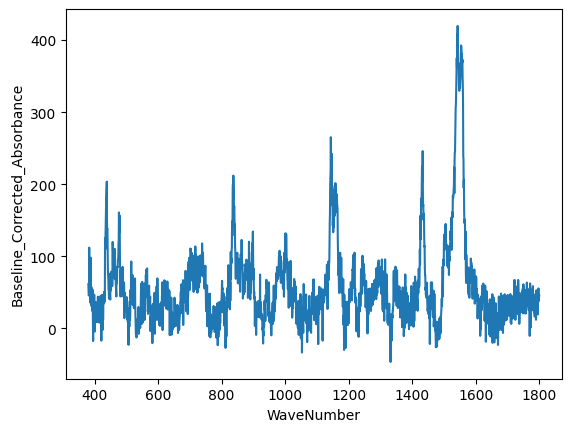

In [ ]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Remove the noise from the spectra using Savitzky–Golay-filtering on the raw spectrum.

/tmp/ipykernel_21741/2008908675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

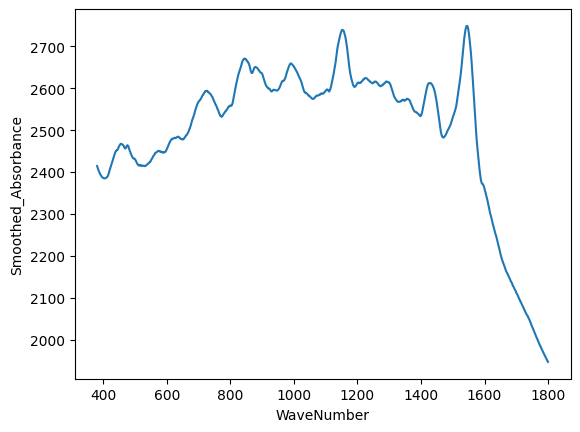

In [ ]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

Try it on the Baseline_Corrected_Spectrum

/tmp/ipykernel_21741/1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

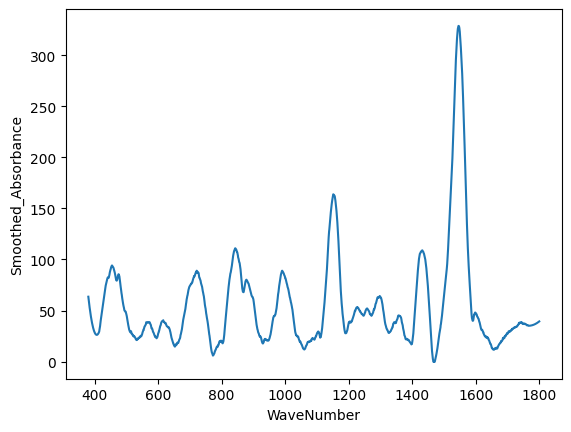

In [ ]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

/tmp/ipykernel_20797/1280720429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, 9, 2, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

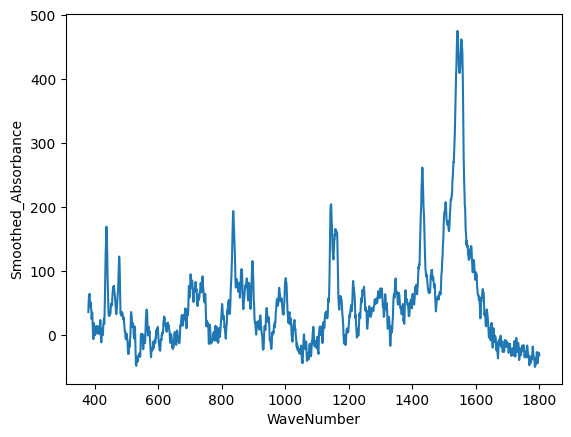

In [ ]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, 9, 2, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

>Based on hand tuned parameters lets see how they affect the Machine Learning Classification.

In [ ]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p, niter=10))

In [ ]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance,Baseline_Corrected_Absorbance
264,201210-1-00,264,380.41003,1843.2512,201210-1,Normal,0.995320,1843.2512,0.995320,97.903716
265,201210-1-00,265,381.09338,1839.0771,201210-1,Normal,0.993066,1839.0771,0.993066,93.886492
266,201210-1-00,266,381.77676,1825.5864,201210-1,Normal,0.985781,1825.5864,0.985781,80.552667
267,201210-1-00,267,382.46014,1820.9634,201210-1,Normal,0.983285,1820.9634,0.983285,76.086543
268,201210-1-00,268,383.14349,1823.1549,201210-1,Normal,0.984468,1823.1549,0.984468,78.434918


In [ ]:
baseline_corrected_df = prepare_wavelength_df(df, 'Baseline_Corrected_Absorbance')

In [ ]:
baseline_corrected_df.head()

,380.41003,381.09338,381.77676,382.46014,383.14349,383.82687,384.51025,385.19363,385.87698,386.56036,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,97.903716,93.886492,80.552667,76.086543,78.434918,81.082893,61.505868,57.196843,59.528518,71.793592,...,-9.464512,-14.913536,-10.996759,0.710818,-14.049305,-12.910328,-28.674050,-27.542672,-32.365294,Normal
201210-1-01,81.383751,60.170315,58.473878,89.395842,83.276805,102.623368,74.781732,62.562595,35.164758,37.177621,...,-39.879207,3.851507,-14.644480,-17.222965,-23.295351,-23.804037,-22.343422,-14.597708,-5.051993,Normal
201210-1-02,126.624977,132.201105,139.020132,141.838260,157.021987,132.691114,117.100241,137.322168,141.266694,133.524620,...,-25.706324,-46.031593,-32.929161,-25.372528,-42.014494,-44.873861,-25.799026,-46.288792,-49.012658,Normal
201210-1-03,310.465716,317.692465,309.022014,275.937064,283.171913,300.067061,247.661110,255.946957,250.984004,232.336450,...,-66.145975,-82.983113,-51.838649,-71.747584,-62.591018,-65.299252,-53.610385,-31.836518,-68.465852,Normal
201210-1-04,117.858214,119.258767,142.555420,131.423773,85.448426,122.483579,109.630531,122.847384,115.387836,81.063388,...,-50.248274,-41.837337,-97.101199,-86.417360,-85.012920,-79.535079,-62.027538,-78.061397,-40.680655,Normal


In [ ]:
evaluate_extra_trees(baseline_corrected_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8949 +/- 0.0169


Scale the Baseline Corrected Absorbances to the highest peak.

In [ ]:
df['Scaled_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: normalise(x))

In [ ]:
scaled_baseline_df = prepare_wavelength_df(df, 'Scaled_Baseline_Corrected')

In [ ]:
evaluate_extra_trees(scaled_baseline_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8447 +/- 0.0171


> Lets try 2 different Savitsky Golay Approaches on the Raw and Baseline Corrected Spectra with and without scaling

In [ ]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [ ]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [ ]:
evaluate_extra_trees(smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8407 +/- 0.0200


In [ ]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [ ]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [ ]:
evaluate_extra_trees(scaled_smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8470 +/- 0.0178


In [ ]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [ ]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [ ]:
evaluate_extra_trees(smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8296 +/- 0.0158


In [ ]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [ ]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [ ]:
evaluate_extra_trees(scaled_smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8617 +/- 0.0244


Try this on the baseline corrected spectra.

In [ ]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [ ]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [ ]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9130 +/- 0.0210


In [ ]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [ ]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [ ]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8637 +/- 0.0249


In [ ]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [ ]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [ ]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9238 +/- 0.0121


In [ ]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [ ]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [ ]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8818 +/- 0.0256


This is worse, lets try vector normalisation, where the spectra are scaled by their euclidean norm.

In [ ]:
def vector_normalise(absorbances):
    l2_norm = np.sqrt(np.sum(absorbances**2))  # Calculate the euclidean norm
    normalized_absorbances = absorbances / l2_norm
    return normalized_absorbances

df['Vector_Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: vector_normalise(x))

In [ ]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: vector_normalise(x))

In [ ]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [ ]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8864 +/- 0.0210


----

The negative impact of scaling the unsmoothed baseline is strange.

In [ ]:
df['No_Below_Baseline'] = np.where(df['Baseline_Corrected_Absorbance'] < 0, 0, df['Baseline_Corrected_Absorbance'])

In [ ]:
no_negative = prepare_wavelength_df(df, 'No_Below_Baseline')

In [ ]:
evaluate_extra_trees(no_negative)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8910 +/- 0.0159


Then with scaling.

In [ ]:
df['Scaled_No_Below_Baseline'] = np.where(df['Scaled_Baseline_Corrected'] < 0, 0, df['Scaled_Baseline_Corrected'])

In [ ]:
scaled_no_negative = prepare_wavelength_df(df, 'Scaled_No_Below_Baseline')

In [ ]:
scaled_no_negative.head()

,380.41003,381.09338,381.77676,382.46014,383.14349,383.82687,384.51025,385.19363,385.87698,386.56036,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.552822,0.530139,0.454848,0.429630,0.442890,0.457842,0.347299,0.322967,0.336133,0.405389,...,0.0,0.000000,0.0,0.004014,0.0,0.0,0.0,0.0,0.0,Normal
201210-1-01,0.358114,0.264769,0.257304,0.393370,0.366444,0.451576,0.329063,0.275295,0.154736,0.163593,...,0.0,0.016948,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
201210-1-02,0.078562,0.082022,0.086252,0.088001,0.097421,0.082326,0.072653,0.085199,0.087646,0.082843,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
201210-1-03,0.289519,0.296258,0.288172,0.257320,0.264066,0.279821,0.230951,0.238678,0.234050,0.216661,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
201210-1-04,0.385483,0.390064,0.466261,0.429853,0.279479,0.400612,0.358573,0.401801,0.377403,0.265137,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal


In [ ]:
evaluate_extra_trees(scaled_no_negative)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8430 +/- 0.0211


Try Min-Max Scaling Instead

In [ ]:
def min_max_scale(absorbances):
    min_value = np.min(absorbances)
    max_value = np.max(absorbances)
    return (absorbances - min_value) / (max_value - min_value)

df['MinMax_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: min_max_scale(x))

In [ ]:
min_max_raw_df = prepare_wavelength_df(df, 'MinMax_Absorbance')

In [ ]:
evaluate_extra_trees(min_max_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8519 +/- 0.0183


In [ ]:
df['MinMax_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: min_max_scale(x))

In [ ]:
min_max_baseline_df = prepare_wavelength_df(df, 'MinMax_Baseline')

In [ ]:
min_max_baseline_df.head()

,380.41003,381.09338,381.77676,382.46014,383.14349,383.82687,384.51025,385.19363,385.87698,386.56036,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.677009,0.660625,0.606243,0.588028,0.597606,0.608406,0.528561,0.510987,0.520497,0.570520,...,0.239111,0.216887,0.232862,0.280611,0.220412,0.225057,0.160765,0.165380,0.145711,Normal
201210-1-01,0.506361,0.434574,0.428833,0.533474,0.512767,0.578237,0.484019,0.442669,0.349954,0.356765,...,0.096002,0.243988,0.181397,0.172671,0.152122,0.150401,0.155343,0.181555,0.213858,Normal
201210-1-02,0.142548,0.145768,0.149705,0.151332,0.160098,0.146050,0.137049,0.148724,0.151002,0.146532,...,0.054600,0.042865,0.050430,0.054793,0.045185,0.043534,0.054547,0.042717,0.041144,Normal
201210-1-03,0.397351,0.403067,0.396209,0.370039,0.375761,0.389125,0.347672,0.354227,0.350301,0.335551,...,0.099452,0.086134,0.110769,0.095021,0.102264,0.100122,0.109368,0.126591,0.097617,Normal
201210-1-04,0.543532,0.546935,0.603535,0.576490,0.464792,0.554770,0.523543,0.555654,0.537530,0.454138,...,0.135113,0.155547,0.021282,0.047239,0.050651,0.063960,0.106495,0.067540,0.158358,Normal


In [ ]:
evaluate_extra_trees(min_max_baseline_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8276 +/- 0.0305


In [ ]:
vector_scale_raw = prepare_wavelength_df(df, "Vector_Scaled_Absorbance")

In [ ]:
evaluate_extra_trees(vector_scale_raw)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9005 +/- 0.0172


Try on the baseline corrected spectra.

In [ ]:
df['Vector_Scaled_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: vector_normalise(x))

In [ ]:
vector_scale_baseline = prepare_wavelength_df(df, 'Vector_Scaled_Baseline')

In [ ]:
evaluate_extra_trees(vector_scale_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8483 +/- 0.0230
